<a href="https://colab.research.google.com/github/takanto/FER2013/blob/main/FER2013_ViT_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FER2013 ViT Implementation**

The GoogleColab used to train ViT.


###**Importing libraries**

In [ ]:
! pip install pillow-heif
! pip install opendatasets
! pip install opencv-contrib-python-headless
!pip install transformers datasets evaluate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pandas as pd
import os
import opendatasets as od
from matplotlib import pyplot
from math import sqrt
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform
from matplotlib.pylab import rcParams
from PIL import Image
import itertools
import glob
import random
from pillow_heif import register_heif_opener
from skimage import io
import pprint
import tempfile
from IPython import display
import cv2
from datasets import load_dataset
from transformers import AutoImageProcessor, DefaultDataCollator, create_optimizer, TFAutoModelForImageClassification
from transformers.keras_callbacks import KerasMetricCallback
import evaluate
%matplotlib inline

###**Loading Dataset**

In [3]:
dataset = 'https://www.kaggle.com/datasets/deadskull7/fer2013'

od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: takanto
Your Kaggle Key: ··········


100%|██████████| 96.6M/96.6M [00:01<00:00, 58.6MB/s]


In [4]:
df = pd.read_csv('fer2013/fer2013.csv')

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


###**Data preprocessing**

In [6]:
X = np.array(list(map(str.split, df.pixels)), np.float32)

In [7]:
X = X.reshape(X.shape[0], 48, 48, 1)
X = np.stack((X,)*3, axis=-1)
X = X.reshape(X.shape[0], 48, 48, 3)

In [11]:
y = np.array(df.emotion)

###**Exploratory data analysis**

In [25]:
emotion_dict = {
            0:'angry',
            1:'disgust',
            2:'fear',
            3:'happy',
            4:'sad',
            5:'surprise',
            6:'neutral',
        }

In [26]:
y_unique, counts = np.unique(y, return_counts=True)
y_unique = [emotion_dict[i] for i in y_unique]

df = pd.DataFrame({
    "emotion": y_unique,
    "count": counts
})

df

,emotion,count
0,angry,4953
1,disgust,547
2,fear,5121
3,happy,8989
4,sad,6077
5,surprise,4002
6,neutral,6198


Then, the function below can plot 9 randomely selected images in np.array. The data can deal with plotting any dimenstion and color map.

In [15]:
def plot_rand_imgs(data, img_size, pred='nan', actual='nan'):
  """
  choose 9 random images stored in numpy array and plot them

  Parameters
  -----------------
  data (numpy array): numpy array containing images
  img_size (tuple): image size of images

  Returns
  -----------------
  None (show plot)
  """
  # images selected
  random_ids = np.random.choice(data.shape[0], 9)

  # for every image, plot it as a subplot
  j = 0
  fig = plt.figure()
  for i in random_ids:
    ax = plt.subplot(330 + 1 + j)
    ax.axis('off')
    # if there is a list of predictions, display it as title
    if type(actual) != str:
      title = f'actual: {actual[i]}'
      if type(pred) != str:
        title += f', pred: {pred[i]}'
      ax.title.set_text(title)
    # if RGB is stored, convert it to RGB
    img = data[i]
    if img_size[2]==3:
      ax.imshow(cv2.cvtColor(img.reshape(img_size[0], img_size[1], 3), cv2.COLOR_BGR2RGB))
    # if grayscale is stored, plot it with gray color map
    elif img_size[2]==1:
      ax.imshow(img.reshape(img_size[0], img_size[1], 1), plt.get_cmap('gray'))

    j += 1

  plt.axis('off')
  plt.show()

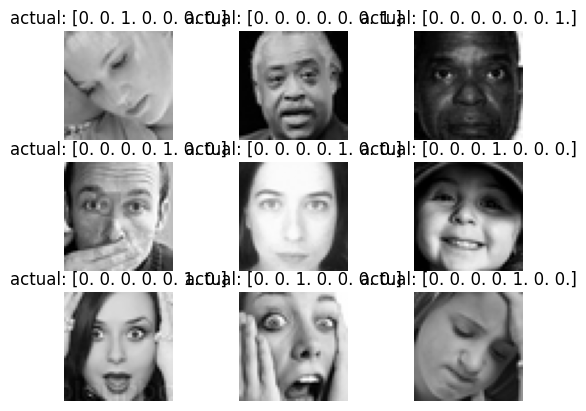

In [16]:
plot_rand_imgs(X, img_size=(48,48,3), actual=y)

###**Data Augmentation**

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [62]:
def save_images(images, labels, folder_path):
    # Create train and test directories if they don't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Loop through each image and label
    for i in range(len(images)):
        label = labels[i]
        image = images[i]

        # Create label directory if it doesn't exist
        label_folder = os.path.join(folder_path, emotion_dict[label])
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

        # Convert numpy array to PIL Image
        image = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
        image_pil = Image.fromarray(image.astype('uint8'))

        # Save image as JPEG file
        image_pil.save(os.path.join(label_folder, f"{i}.jpeg"))

In [64]:
save_images(X_train, y_train, "FER2013/train")
save_images(X_test, y_test, "FER2013/test")

In [66]:
dataset = load_dataset("imagefolder", data_dir="FER2013")

Resolving data files:   0%|          | 0/28709 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7178 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [67]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [68]:
id2label[str(2)]

'fear'

In [69]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [70]:
size = (image_processor.size["height"], image_processor.size["width"])

In [71]:
size

(224, 224)

In [83]:
rescaling = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="rescaling",
)

In [84]:
def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)

def preprocessing(example_batch):
    images = [
        rescaling(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [85]:
dataset["train"].set_transform(preprocessing)
dataset["test"].set_transform(preprocessing)

In [86]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [87]:
accuracy = evaluate.load("accuracy")

In [76]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [88]:
batch_size = 16
num_epochs = 5
num_train_steps = len(dataset["train"]) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [89]:
model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
tf_train_dataset = dataset["train"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = dataset["test"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

In [91]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [92]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_eval_dataset)
callbacks = [metric_callback]

In [93]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/5
1795/1795 [==============================] - 1376s 757ms/step - loss: 1.1841 - val_loss: 1.0107 - accuracy: 0.6262
Epoch 2/5
1795/1795 [==============================] - 1416s 789ms/step - loss: 0.8483 - val_loss: 0.9316 - accuracy: 0.6552
Epoch 3/5
1795/1795 [==============================] - 1376s 767ms/step - loss: 0.6117 - val_loss: 0.9547 - accuracy: 0.6719
Epoch 4/5
1795/1795 [==============================] - 1376s 766ms/step - loss: 0.3765 - val_loss: 1.0548 - accuracy: 0.6640
Epoch 5/5
1795/1795 [==============================] - 1393s 776ms/step - loss: 0.2114 - val_loss: 1.2081 - accuracy: 0.6636


###**Saving the model**

H5

In [98]:
model.save_pretrained('model_dir/fer13_vit_pt', from_pt=True)

In [95]:
#model.save('fer13_vit.h5')
model_weights = model.get_weights()

model_dir = "model_dir"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
np.save(os.path.join(model_dir, 'fer13_vit_weights'), model_weights)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


TFLite

In [96]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite = converter.convert()

with open("fer13_vit.tflite", "wb") as f:
  f.write(tflite)

###**Inference**

In [101]:
dataset = load_dataset("imagefolder", data_dir="FER2013")

Resolving data files:   0%|          | 0/28709 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7178 [00:00<?, ?it/s]

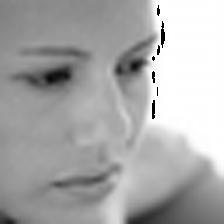

In [140]:
index = 1100
image = dataset['test'][index]['image']
label = dataset['test'][index]['label']

image

In [141]:
inputs = image_processor(image, return_tensors="tf")
logits = model(**inputs).logits

In [142]:
logits

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-1.9363952 , -1.1345623 ,  0.18018083,  1.31778   , -0.45063198,
         1.4888197 , -0.24018262]], dtype=float32)>

In [143]:
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
print('predicted: ',model.config.id2label[str(predicted_class_id)])
print('actual: ', emotion_dict[label])

predicted:  sad
actual:  fear
